# Analyse Partie 2 : Multi-Agents (SMA)

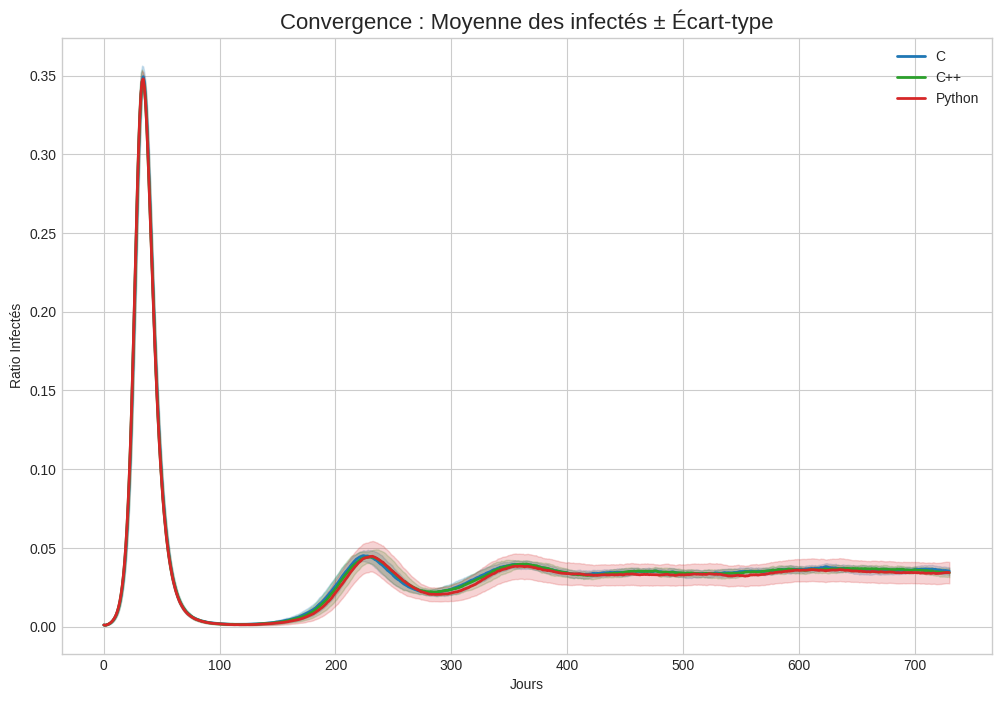

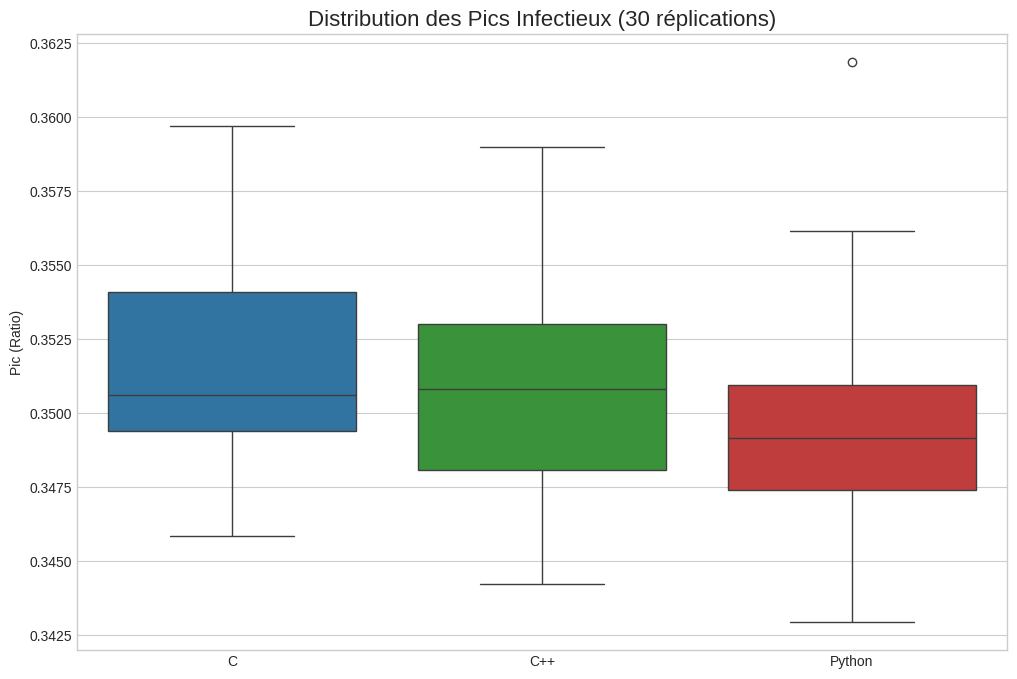

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize']=(12,8)

def load(p): 
    fs = sorted(glob.glob(p))
    l = [pd.read_csv(f) for f in fs]
    return l

dc = load('res_c_*.csv')
dcpp = load('res_cpp_*.csv')
dpy = load('res_py_*.csv')

# Fonction Convergence
def plot_conv(data, lbl, col):
    df = pd.concat(data)
    grp = df.groupby(df.index)
    mu = grp['I'].mean()/20000
    std = grp['I'].std()/20000
    plt.plot(mu, label=lbl, color=col, linewidth=2)
    plt.fill_between(mu.index, mu-std, mu+std, color=col, alpha=0.2)

plt.figure()
plot_conv(dc, 'C', '#1f77b4')
plot_conv(dcpp, 'C++', '#2ca02c')
plot_conv(dpy, 'Python', '#d62728')
plt.title('Convergence : Moyenne des infectés ± Écart-type', fontsize=16)
plt.xlabel('Jours')
plt.ylabel('Ratio Infectés')
plt.legend()
plt.show()

# Boxplot
p_c = [d['I'].max()/20000 for d in dc]
p_cpp = [d['I'].max()/20000 for d in dcpp]
p_py = [d['I'].max()/20000 for d in dpy]

plt.figure()
df_box = pd.DataFrame({'C':p_c, 'C++':p_cpp, 'Python':p_py})
sns.boxplot(data=df_box, palette=['#1f77b4', '#2ca02c', '#d62728'])
plt.title('Distribution des Pics Infectieux (30 réplications)', fontsize=16)
plt.ylabel('Pic (Ratio)')
plt.show()

## Analyse statistique

In [ ]:
## Analyse statistique : Comparaison des langages

from scipy import stats

print("="*70)
print("ANALYSE STATISTIQUE DES RÉSULTATS")
print("="*70)

# 1. Extraction hauteur et date du 1er pic
def extract_first_peak(data_list):
    heights = []
    dates = []
    for df in data_list:
        # Limiter aux 150 premiers jours pour capturer le 1er pic
        df_early = df[df['jour'] <= 150]
        peak_idx = df_early['I'].idxmax()
        heights.append(df_early.loc[peak_idx, 'I'] / 20000)  # ratio
        dates.append(df_early.loc[peak_idx, 'jour'])
    return heights, dates

h_c, d_c = extract_first_peak(dc)
h_cpp, d_cpp = extract_first_peak(dcpp)
h_py, d_py = extract_first_peak(dpy)

print("\n### Statistiques descriptives ###")
print(f"\nHauteur 1er pic (ratio):")
print(f"  C     : mean={np.mean(h_c):.6f}, std={np.std(h_c):.6f}")
print(f"  C++   : mean={np.mean(h_cpp):.6f}, std={np.std(h_cpp):.6f}")
print(f"  Python: mean={np.mean(h_py):.6f}, std={np.std(h_py):.6f}")

print(f"\nDate 1er pic (jours):")
print(f"  C     : mean={np.mean(d_c):.1f}, std={np.std(d_c):.1f}")
print(f"  C++   : mean={np.mean(d_cpp):.1f}, std={np.std(d_cpp):.1f}")
print(f"  Python: mean={np.mean(d_py):.1f}, std={np.std(d_py):.1f}")

# 2. Tests de normalité
print("\n### Tests de normalité (Shapiro-Wilk) ###")
_, p_h_c = stats.shapiro(h_c)
_, p_h_cpp = stats.shapiro(h_cpp)
_, p_h_py = stats.shapiro(h_py)

print(f"\nHauteur 1er pic:")
print(f"  C     : p-value={p_h_c:.4f} {'(normal)' if p_h_c>0.05 else '(non-normal)'}")
print(f"  C++   : p-value={p_h_cpp:.4f} {'(normal)' if p_h_cpp>0.05 else '(non-normal)'}")
print(f"  Python: p-value={p_h_py:.4f} {'(normal)' if p_h_py>0.05 else '(non-normal)'}")

# 3. Choix du test: ANOVA si normal, Kruskal-Wallis sinon
if p_h_c > 0.05 and p_h_cpp > 0.05 and p_h_py > 0.05:
    stat, p_val = stats.f_oneway(h_c, h_cpp, h_py)
    test_name = "ANOVA"
else:
    stat, p_val = stats.kruskal(h_c, h_cpp, h_py)
    test_name = "Kruskal-Wallis"

print(f"\n### Test {test_name} sur hauteur 1er pic ###")
print(f"Statistique: {stat:.4f}")
print(f"p-value: {p_val:.4f}")

if p_val > 0.05:
    print(f"\n CONCLUSION: Pas de différence significative (p={p_val:.4f} > 0.05)")
    print("  Les 3 langages produisent des résultats statistiquement identiques")
else:
    print(f"\n CONCLUSION: Différence significative (p={p_val:.4f} < 0.05)")
    print("  Les 3 langages produisent des résultats différents")


ANALYSE STATISTIQUE DES RÉSULTATS

### Statistiques descriptives ###

Hauteur 1er pic (ratio):
  C     : mean=0.351700, std=0.003213
  C++   : mean=0.350592, std=0.003335
  Python: mean=0.349690, std=0.003465

Date 1er pic (jours):
  C     : mean=33.9, std=0.9
  C++   : mean=33.6, std=1.1
  Python: mean=33.7, std=0.7

### Tests de normalité (Shapiro-Wilk) ###

Hauteur 1er pic:
  C     : p-value=0.3062 (normal)
  C++   : p-value=0.8958 (normal)
  Python: p-value=0.0023 (non-normal)

### Test Kruskal-Wallis sur hauteur 1er pic ###
Statistique: 7.4998
p-value: 0.0235

✗ CONCLUSION: Différence significative (p=0.0235 < 0.05)
  Les 3 langages produisent des résultats différents
